In [ ]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

# Access the vocabulary
vocab = tokenizer.get_vocab()

# Convert the vocabulary to a list of tokens
vocab_list = list(vocab.keys())

vocab_list

In [ ]:
# test gpu connection
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

In [ ]:
import pandas as pd
from pathlib import Path

# Define file paths
file_path_deu = Path.cwd() / "data" / "deu.list"
file_path_eng = Path.cwd() / "data" / "eng.list"
file_path_ned = Path.cwd() / "data" / "ned.list.PER"

# Function to read and process file into a DataFrame
def read_and_process_file(file_path):
    with open(file_path, 'r',encoding='latin-1') as file:
        lines = file.readlines()
    data = [line.strip().split(' ', 1) for line in lines]
    return pd.DataFrame(data, columns=['NER', 'Entity'])

# Read and process files
NER_df_deu = read_and_process_file(file_path_deu)
NER_df_eng = read_and_process_file(file_path_eng)
NER_df_ned = read_and_process_file(file_path_ned)

# Filter English DataFrame to use only 'PER' entities
NER_df_eng = NER_df_eng[NER_df_eng['NER'] == 'PER']

# Combine all DataFrames
NER_df = pd.concat([NER_df_deu, NER_df_eng, NER_df_ned])

NER_df['NER'] = NER_df['NER'].replace('LOC', 'Ort:')
NER_df['NER'] = NER_df['NER'].replace('PER', 'Person:')
NER_df['NER'] = NER_df['NER'].replace('ORG', 'Organisation:')

# Convert DataFrame to list of elements
def create_training_data(row):
    if row['NER'] == 'MISC':
        return f"{row['Entity']}"
    else:
        return f"{row['NER']} {row['Entity']}"

NER_list = [create_training_data(row) for _, row in NER_df.iterrows()]
NER_list


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
model = BertModel.from_pretrained('bert-base-german-cased')

vocab_size = tokenizer.vocab_size

# Function to get embeddings for a list of tokens
def get_embeddings(tokens):
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v).unsqueeze(0) for k, v in tokens.items()})
    return outputs.last_hidden_state.squeeze(0)

# Process each element in NER_list
rows = []
for element in NER_list:
    
    full_tokens = tokenizer(element, padding=False, truncation=False, add_special_tokens=True)
    
    # Get embeddings for the full tokenized input
    full_embeddings = get_embeddings(full_tokens)
    
    # Split the element into NER type and entity
    parts = element.split(': ', 1)
    entity = parts[1] if len(parts) > 1 else element
    
    # Tokenize the entity separately (without special tokens)
    entity_tokens = tokenizer(entity, padding=False, truncation=False, add_special_tokens=False)
    
    # Find the start index of entity tokens in the full tokenization
    start_index = 1  # Skip [CLS]
    if len(parts) > 1:
        start_index += len(tokenizer(parts[0] + ':', add_special_tokens=False)['input_ids'])
    
    # Process each token in the entity
    tokens = []
    token_ids = []
    token_embeddings = []
    for i, token_id in enumerate(entity_tokens['input_ids']):
        token = tokenizer.decode([token_id])
        token_embedding = full_embeddings[start_index + i]
        
        tokens.append(token)
        token_ids.append(token_id)
        token_embeddings.append(token_embedding.tolist())
    
    # Add the end of sequence token ID
    token_ids.append(4) #[SEP]
    token_ids.insert(0,3) #[CLS]
    # Calculate average embedding for the entity tokens
    avg_embedding = torch.mean(full_embeddings[start_index:start_index+len(entity_tokens['input_ids'])], dim=0).tolist()
    
    
    rows.append({
        'Entity': entity,
        'Tokens': tokens,
        'Token_IDs': token_ids,#token_ids[1:-1] w/ [CLS] and [SEP]
        'Token_Embeddings': token_embeddings,
        'Average_Embedding': avg_embedding,
        'Target_Token_IDs': token_ids
    })

# Create DataFrame
df = pd.DataFrame(rows)
# check if any element in the list contains '[UNK]'
def contains_unk(token_list):
    return any('[UNK]' in token for token in token_list)

# Filter out rows where the Token column contains '[UNK]'
df = df[~df['Tokens'].apply(contains_unk)]
# Filter out rows that are longer than 15 Tokens 
df = df[df['Target_Token_IDs'].apply(len) <= 15]
df = df.reset_index(drop=True)

df

/home/mseiferling/.venvs/embed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Entity,Tokens,Token_IDs,Token_Embeddings,Average_Embedding,Target_Token_IDs
0,A 5,"[A, 5]","[32, 435, 4]","[[0.5321832895278931, 0.15855109691619873, 0.2...","[-0.24310845136642456, 0.13687995076179504, -0...","[32, 435, 4]"
1,A 66,"[A, 66]","[32, 10092, 4]","[[0.4871409237384796, 0.3022191524505615, 0.23...","[0.32661712169647217, 0.14974229037761688, 0.1...","[32, 10092, 4]"
2,A 661,"[A, 66, ##1]","[32, 10092, 26927, 4]","[[0.33346572518348694, 0.23834776878356934, -0...","[0.12139879912137985, 0.2494209259748459, 0.05...","[32, 10092, 26927, 4]"
3,Aalen,"[A, ##alen]","[32, 609, 4]","[[0.07099006325006485, -0.5678775310516357, 1....","[-0.003420088440179825, -0.260809063911438, 0....","[32, 609, 4]"
4,Aare-Mündung,"[Aar, ##e, -, Mündung]","[15576, 26897, 26935, 14955, 4]","[[0.3378963768482208, -0.5541061162948608, -0....","[0.2187633365392685, -0.3105980157852173, 0.07...","[15576, 26897, 26935, 14955, 4]"
...,...,...,...,...,...,...
47762,Zyg,"[Zy, ##g]","[10373, 26908, 4]","[[-0.36112070083618164, -0.00450560450553894, ...","[0.005554556846618652, 0.19277839362621307, -0...","[10373, 26908, 4]"
47763,Zygmunt,"[Zy, ##g, ##m, ##unt]","[10373, 26908, 26911, 1937, 4]","[[-0.20858515799045563, -0.4874523878097534, -...","[0.246858611702919, -0.13464316725730896, -0.2...","[10373, 26908, 26911, 1937, 4]"
47764,Zyj,"[Zy, ##j]","[10373, 26963, 4]","[[-0.07781310379505157, 0.8064130544662476, -0...","[-0.12115689367055893, 0.37860164046287537, -0...","[10373, 26963, 4]"
47765,Zyk,"[Zy, ##k]","[10373, 26917, 4]","[[-0.4067027270793915, 0.1616303026676178, 0.6...","[-0.3863324820995331, -0.24419178068637848, 0....","[10373, 26917, 4]"


In [16]:
# determine the longest sequence
print(f"max length: {df['Target_Token_IDs'].apply(len).max()}")
print(df['Target_Token_IDs'].apply(len).value_counts().sort_index())

max length: 16
Target_Token_IDs
3      2115
4     13098
5     12997
6      8888
7      5205
8      2500
9      1037
10      403
11      149
12       97
13       36
14        9
15       10
16        7
Name: count, dtype: int64


In [ ]:
import pandas as pd
from pathlib import Path
# Save the DataFrame to the specified path
file_path_df = Path.cwd() / "data" / "df_file.pkl"

# #Save the DataFrame to a pickle file
#df.to_pickle(file_path_df)

# #Load the DataFrame from the pickle file
df= pd.read_pickle(file_path_df)
df
##### adding Special Tokens 
#df['Target_Token_IDs'] = df['Target_Token_IDs'].apply(lambda x: [3] + x)
#df['Token_IDs'] = df['Token_IDs'].apply(lambda x: x[:-1])


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the average embedding (input)
        avg_embedding = torch.tensor(self.data.iloc[idx]['Average_Embedding'], dtype=torch.float32)
        
        # Get the token IDs (target)
        token_ids = torch.tensor(self.data.iloc[idx]['Target_Token_IDs'], dtype=torch.int64)
        
        return avg_embedding, token_ids

def collate_fn(batch):
    # Separate inputs and targets
    inputs, targets = zip(*batch)
    # Pad the target sequences
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    # Stack the inputs 
    inputs_stacked = torch.stack(inputs)
    
    return inputs_stacked, targets_padded

# # Create the dataset
# full_dataset = CustomDataset(df)

# # Calculate split sizes
# total_size = len(full_dataset)
# train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
# test_size = total_size - train_size - val_size

# # Split the dataset
# train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [26]:
import pandas as pd
import pickle
from pathlib import Path
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Save the DataFrame to the specified path
file_path_train = Path.cwd() / "data" / "train_dataset.pkl"
file_path_test = Path.cwd() / "data" / "test_dataset.pkl"
file_path_val = Path.cwd() / "data" / "val_dataset.pkl"

######################Save the Data to a pickle file
# with open(file_path_train, 'wb') as f:
#     pickle.dump(train_dataset, f)

# with open(file_path_test, 'wb') as f:
#     pickle.dump(val_dataset, f)

# with open(file_path_val, 'wb') as f:
#     pickle.dump(test_dataset, f)

######################Load the Data from the pickle file
with open(file_path_train, 'rb') as f:
    train_dataset = pickle.load(f)

with open(file_path_test, 'rb') as f:
    val_dataset = pickle.load(f)

with open(file_path_val, 'rb') as f:
    test_dataset = pickle.load(f)

# Create DataLoaders with collate function
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) ########### hyperparameter optimization batch size
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

#Infromation dataloaders
for loader_name, loader in [("Train", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
    print(f"\nInformation {loader_name} loader:")
    for batch in loader:
        print("Input shape:", batch[0].shape)
        print("Target shape:", batch[1].shape)
        print("Input dtype:", batch[0].dtype)
        print("Target dtype:", batch[1].dtype)
        print("Input range:", batch[0].min().item(), batch[0].max().item())
        print("Target range:", batch[1].min().item(), batch[1].max().item())
        break
########################


Information Train loader:
Input shape: torch.Size([256, 768])
Target shape: torch.Size([256, 12])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -2.2604119777679443 16.38422203063965
Target range: 0 26963

Information Validation loader:
Input shape: torch.Size([256, 768])
Target shape: torch.Size([256, 9])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -2.132582426071167 17.16713523864746
Target range: 0 26979

Information Test loader:
Input shape: torch.Size([256, 768])
Target shape: torch.Size([256, 13])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -2.5452218055725098 16.662612915039062
Target range: 0 26979


In [13]:
import torch
import torch.nn as nn
from transformers import BertForMaskedLM
import pandas as pd
class CustomLSTMWithBERTMLM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bert_model_name):
        super().__init__()
        
        self.bert_model = BertForMaskedLM.from_pretrained(bert_model_name)
        
        self.bert_word_embeddings = self.bert_model.bert.embeddings.word_embeddings
        self.bert_position_embeddings = self.bert_model.bert.embeddings.position_embeddings
        self.bert_LayerNorm = self.bert_model.bert.embeddings.LayerNorm
        
        self.lstm = nn.LSTM(input_size + hidden_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        self.bert_mlm_head = self.bert_model.cls
        
        # Remove these lines to allow fine-tuning
        for param in self.bert_model.parameters():
            param.requires_grad = False
        
        assert hidden_size == self.bert_model.config.hidden_size, "LSTM hidden size must match BERT hidden size"

    def forward(self, x, prev_token_id=None, prev_token_position=None, h=None, c=None):
        batch_size = x.size(0)
        # Handle the case when there's no previous token
        if prev_token_id is None:
            dummy_prev_token = torch.zeros(batch_size, self.bert_model.config.hidden_size).to(x.device)
            input_tensor = torch.cat([x.unsqueeze(1), dummy_prev_token.unsqueeze(1)], dim=2) 
        else:
            # Get embedding for the previous token
            token_embedding = self.bert_word_embeddings(prev_token_id).to(x.device)
            position_embedding = self.bert_position_embeddings(prev_token_position).to(x.device)
            combined_embeddings = token_embedding + position_embedding
            prev_token_embedding = self.bert_LayerNorm(combined_embeddings).to(x.device)
            # Concatenate the average embedding with the previous token embedding
            input_tensor = torch.cat([x.unsqueeze(1), prev_token_embedding], dim=2)
            
        # Initialize hidden state and cell state if not provided
        if h is None:
            h = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        if c is None:
            c = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        
        out, (h, c) = self.lstm(input_tensor, (h, c))
        if self.training: # only use dropout druing training
            out = self.dropout(out)
        out = self.layer_norm(out)
        mlm_output = self.bert_mlm_head(out)  # Shape: (batch_size, 1, vocab_size)
        
        return mlm_output, h, c  

/home/mseiferling/.venvs/embed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import datetime
from torch.optim.lr_scheduler import StepLR  #or CosineAnnealingLR
from torch.optim import AdamW
input_size = 768
hidden_size = 768
num_layers = 1 #### hyperparameter optimization
num_epochs = 2
learning_rate = 0.001
weight_decay = 0.01 # L2 regularization factor
batch_size = 256
# CrossEntropyLoss, expect the inputs in a specific format:
# The predictions should be a 2D tensor of shape [N, C] where N is the number of samples and C is the number of classes (vocab size in this case).
# The targets should be a 1D tensor of shape [N] containing the class indices.
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
bert_model_name = 'bert-base-german-cased'
model = CustomLSTMWithBERTMLM(input_size, hidden_size, num_layers, bert_model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Decays the learning rate every 10 epochs by a factor of 0.1
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Train Sequence Model:

In [ ]:
class CustomLSTMWithBERTMLM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, max_seq_length, bert_model_name):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        ####self.dropout = nn.Dropout(0.1)
        ####self.layer_norm = nn.LayerNorm(hidden_size)
        self.max_seq_length = max_seq_length
        
        self.bert_mlm = BertForMaskedLM.from_pretrained(bert_model_name)
        #### Remove these lines to allow fine-tuning
        for param in self.bert_mlm.parameters():
            param.requires_grad = False
        
        assert hidden_size == self.bert_mlm.config.hidden_size, "LSTM hidden size must match BERT hidden size"

    def forward(self, x):
        batch_size = x.size(0)
        
        # Use the input to initialize the hidden state
        h = x.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1) #shape:(num_layers, batch_size, hidden_size)
        c = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        
        # dummy input for the LSTM
        dummy_input = torch.zeros(batch_size, 1, self.lstm.hidden_size).to(x.device)
        outputs = []
        for i in range(self.max_seq_length):
            out, (h, c) = self.lstm(dummy_input, (h, c))
            ####out = self.dropout(out)
            ####out = self.layer_norm(out)
            mlm_output = self.bert_mlm.cls(out)
            
            outputs.append(mlm_output)
        
        output_tensor = torch.cat(outputs, dim=1)
        return output_tensor # output shape: (batch_size, generated_seq_length, vocab_size)

In [ ]:
# Create log file with current date and time
current_time_start_epoch = datetime.datetime.now().strftime("%d.%m.%Y_%H:%M:%S")
log_path = Path.cwd() / "log" / f"log_{current_time_start_epoch}.txt"
# log hyperparameters and model information
with open(log_path, 'w') as log_file:
    log_file.write(f"Model Architecture: {model}\n\n")
    log_file.write(f"BERT model: {bert_model_name}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Input size: {input_size}\n")
    log_file.write(f"Hidden size: {hidden_size}\n")
    log_file.write(f"Number of layers: {num_layers}\n")
    log_file.write(f"Max sequence length: {max_seq_length}\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Loss function: CrossEntropyLoss\n")
    log_file.write(f"Number of epochs: {num_epochs}\n\n")
    
best_model_path = Path.cwd() / "data" / "best_model.pth"
best_test_loss = float('inf')

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for batch in train_loader:
        inputs, targets = batch
        # inference with batch
        outputs = model(inputs)
        # processing of output and target for training
        outputs = outputs[:, :targets.shape[1], :] # we only need to consider the outputs for which we have a target during training
        outputs = outputs.reshape(-1, outputs.size(-1)) # Reshape outputs from [batch_size, sequence_length, vocab_size] to be [batch_size * sequence_length, vocab_size]  
        targets = targets.reshape(-1) # Reshape targets from [batch_size, sequence_length] to be [batch_size * sequence_length] 
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backpropagation and optimization
        optimizer.zero_grad() # this resets the gradients of all parameters to zero from last batch
        loss.backward() # computes the gradient of the loss with respect to each parameter of the model
        optimizer.step() # updates the parameters based on the computed gradients
    
        epoch_train_losses.append(loss.item())
   
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)
    
    # Compute test loss
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            
            outputs = model(inputs)
            
            outputs = outputs[:, :targets.shape[1], :]
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = targets.reshape(-1)
            
            loss = criterion(outputs, targets)
            
            epoch_test_losses.append(loss.item())
    
    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)
    
    # Save the model if the test loss is the best seen so far
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_test_loss,
        }, best_model_path)
        
    # Log epoch information
    with open(log_path, 'a') as log_file:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}] - {current_time}\n")
        log_file.write(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}\n\n")
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("Training finished!")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# get the best loss for the filename
best_loss_str = f"{best_test_loss:.4f}".replace('.', '_')

# Construct the file path
plot_file_path = Path.cwd() / "log" / f"loss_plot_{current_time_start_epoch}.png"

# Save the plot
plt.savefig(plot_file_path)

# Show the plot
plt.show()

#### Implement more comprehensive evaluation metrics (e.g., perplexity, BLEU score for generated text).

## Train Autoregressive Model

In [31]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model, optimizer):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}\n\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n\n')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, self.path)
        self.val_loss_min = val_loss
        
def log_to_file(message, log_path):
    with open(log_path, 'a') as log_file:
        log_file.write(message)


Epoch [1/2], Train Loss: 18.7690, Test Loss: 22.8057
Epoch [2/2], Train Loss: 11.3890, Test Loss: 21.7569
Training finished!


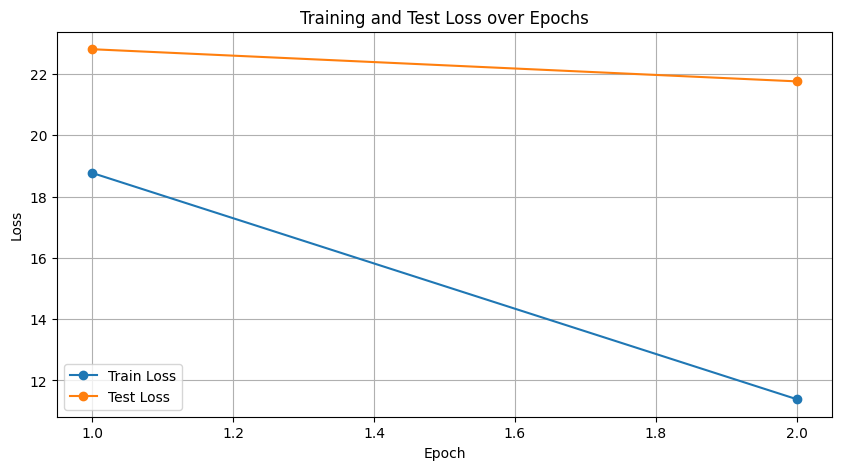

In [30]:
# Create log file with current date and time
current_time_start_epoch = datetime.datetime.now().strftime("%d.%m.%Y_%H:%M:%S")
log_path = Path.cwd() / "log" / f"log_{current_time_start_epoch}.txt"
# log hyperparameters and model information
with open(log_path, 'w') as log_file:
    log_file.write(f"Model Architecture: {model}\n\n")
    log_file.write(f"BERT model: {bert_model_name}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Input size: {input_size}\n")
    log_file.write(f"Hidden size: {hidden_size}\n")
    log_file.write(f"Number of layers: {num_layers}\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"weight decay: {weight_decay}\n")
    log_file.write(f"Loss function: CrossEntropyLoss\n")
    log_file.write(f"Number of epochs: {num_epochs}\n\n")
    
# Initialize early stopping
best_model_path = Path.cwd() / "data" / "best_model.pth"
early_stopping = EarlyStopping(patience=0, verbose=True, path=best_model_path, trace_func=lambda msg: log_to_file(msg, log_path))

best_test_loss = float('inf')

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        batch_size, seq_len = targets.shape
        h, c = None, None
        prev_token, prev_position = None, None
        
        optimizer.zero_grad()
        total_batch_loss = 0
        
        for t in range(seq_len - 1):
            if t != 0:
                # Previous token (use ground truth for training)
                prev_token = targets[:, t-1].unsqueeze(1).to(device) 
                prev_position = torch.full((batch_size, 1), t-1, device=device)
            # Forward pass
            output, h, c = model(inputs, prev_token, prev_position, h, c)
            # Compute loss
            batch_loss = criterion(output.squeeze(1), targets[:, t])
            total_batch_loss += batch_loss
        
        # Backward pass and optimize
        total_batch_loss.backward()
        optimizer.step()
    
        epoch_train_losses.append(total_batch_loss.item())
        
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)
    # increment scheduler at the end of each epoch
    scheduler.step()
    
    # Compute test loss
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            batch_size, seq_len = targets.shape
            h, c = None, None
            prev_token, prev_position = None, None
            
            total_batch_loss = 0
            
            for t in range(seq_len - 1):
                if t != 0:
                    # Previous token (use ground truth for training)
                    prev_token = targets[:, t-1].unsqueeze(1)
                    prev_position = torch.full((batch_size, 1), t-1, device=device)
                # Forward pass
                output, h, c = model(inputs, prev_token, prev_position, h, c)
                # Compute loss
                batch_loss = criterion(output.squeeze(1), targets[:, t])
                total_batch_loss += batch_loss
        
            epoch_test_losses.append(total_batch_loss.item())
   
    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)
        
    # Log epoch information
    with open(log_path, 'a') as log_file:
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}] - {current_time} LR: {scheduler.get_last_lr()[0]}\n")
        log_file.write(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}\n\n")
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    # Early stopping
    early_stopping(avg_test_loss, model, optimizer)
    if early_stopping.early_stop:
        print("Early stopping")
        with open(log_path, 'a') as log_file:
            log_file.write("Early stopping\n")
        break

print("Training finished!")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# get the best loss for the filename
best_loss_str = f"{best_test_loss:.4f}".replace('.', '_')

# Construct the file path
plot_file_path = Path.cwd() / "log" / f"loss_plot_{current_time_start_epoch}.png"

# Save the plot
plt.savefig(plot_file_path)

# Show the plot
plt.show()

#### Implement more comprehensive evaluation metrics (e.g., perplexity, BLEU score for generated text).

In [ ]:
# Loading the best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()  # for inference
# to resume training, set the model train mode
# model.train()

In [459]:
df[42000:42050]

,Entity,Tokens,Token_IDs,Token_Embeddings,Average_Embedding,Target_Token_IDs
42000,Tall,[Tall],"[21935, 4]","[[-0.01224720198661089, 0.16867724061012268, -...","[-0.01224720198661089, 0.16867724061012268, -0...","[21935, 4]"
42001,Tam,[Tam],"[17524, 4]","[[0.16409598290920258, 0.793487548828125, -0.7...","[0.16409598290920258, 0.793487548828125, -0.71...","[17524, 4]"
42002,Tamar,"[Tam, ##ar]","[17524, 33, 4]","[[1.1463826894760132, 0.7378958463668823, 0.41...","[0.4127388000488281, 0.5559422373771667, -0.04...","[17524, 33, 4]"
42003,Tamara,"[Tam, ##ara]","[17524, 3738, 4]","[[0.774370014667511, 0.2208947241306305, 0.663...","[0.5452055931091309, 0.20736496150493622, 0.25...","[17524, 3738, 4]"
42004,Tamara Boros,"[Tam, ##ara, Bor, ##os]","[17524, 3738, 3888, 224, 4]","[[1.0219417810440063, 0.18805761635303497, 0.3...","[0.8827532529830933, 0.0814586728811264, 0.267...","[17524, 3738, 3888, 224, 4]"
42005,Tamarine Tanasugarn,"[Tam, ##arin, ##e, Tan, ##as, ##ug, ##arn]","[17524, 22328, 26897, 15297, 45, 389, 7074, 4]","[[0.8510592579841614, -0.1594560146331787, 0.3...","[0.4551093578338623, -0.1477975845336914, 0.10...","[17524, 22328, 26897, 15297, 45, 389, 7074, 4]"
42006,Tamas,"[Tam, ##as]","[17524, 45, 4]","[[1.130900263786316, 0.7732470631599426, 0.357...","[0.6211729049682617, 0.5434377789497375, 0.150...","[17524, 45, 4]"
42007,Tamas Ajan,"[Tam, ##as, A, ##jan]","[17524, 45, 32, 10761, 4]","[[1.140594720840454, 1.101357102394104, 0.5228...","[0.2719385027885437, 0.47032666206359863, 0.33...","[17524, 45, 32, 10761, 4]"
42008,Tamas Szekeres,"[Tam, ##as, Sz, ##ek, ##ere, ##s]","[17524, 45, 14620, 1752, 1031, 26902, 4]","[[1.1150412559509277, 1.2008758783340454, 0.47...","[0.7783443927764893, 0.3929256498813629, 0.270...","[17524, 45, 14620, 1752, 1031, 26902, 4]"
42009,Tambuyser,"[Tam, ##bu, ##yse, ##r]","[17524, 13874, 18940, 26900, 4]","[[0.9211291670799255, 0.2917001247406006, -0.3...","[0.6440316438674927, 0.13280363380908966, -0.0...","[17524, 13874, 18940, 26900, 4]"


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
# # end inference if this token is predicted
# eos_token_id = tokenizer.convert_tokens_to_ids('[SEP]')  # EOS token

# Example forward pass
#input_tensor = torch.randn(1,768)

tensor = torch.tensor(df["Average_Embedding"][42042]).unsqueeze(0) #159
# Generate Gaussian noise
noise_level = 0.6
noise = torch.randn_like(tensor) * noise_level
# Add noise to tensor
input_tensor = tensor + noise


output_tensor = model(input_tensor)

for batch_idx in range(output_tensor.size(0)):
    for position in range(output_tensor.size(1)):  # Iterate over sequence length
        position_probs = output_tensor[batch_idx, position, :]  # Get probabilities for this position
        
        # Get top 5 probabilities
        top_5_values, top_5_indices = torch.topk(position_probs, 1, dim=0)
        
        print(f"Position {position}:")
        for i, (value, index) in enumerate(zip(top_5_values, top_5_indices), 1):
            token = tokenizer.convert_ids_to_tokens([index.item()])[0]
            probability = value.item()
            print(f"  {i}. {token} (probability: {probability:.4f})")
        print()
########################################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

# Example forward pass
input_tensor = torch.randn(2,768)


input_id = torch.tensor([[0],[0]])    # Shape: [2, 1]
position_id = torch.tensor([[0],[0]])  # Shape: [2, 1]

output_tensor,h,c = model(input_tensor,input_id,position_id) # output size:[2, 1, 30000] # h size: [2, 1, 768]# c size:[2, 1, 768]

for batch in train_loader:
    inputs, targets = batch
    print(inputs.shape)
    print(targets.shape)
for batch_idx in range(inputs.size(0)):
        position_probs = output_tensor[batch_idx, 0, :]  # Get probabilities for this position
        # Get top 5 probabilities
        top_values, top_indices = torch.topk(position_probs, 1, dim=0)
        
        for i, (value, index) in enumerate(zip(top_values, top_indices), 1):
            token = tokenizer.convert_ids_to_tokens([index.item()])[0]
            probability = value.item()
            print(f"  {i}. {token} (probability: {probability:.4f})")
        print()
        

In [ ]:
torch.tensor(df["Average_Embedding"][8]).unsqueeze(0).shape